In [1]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fishess-pic/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])
for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")

Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:23<00:00,  2.11s/it]

DONE!


In [2]:
aug_count = sum(len(files) for _,_,files in os.walk(output_dir))
print("TOTAL AUGMENTED IMAGES =", aug_count)

TOTAL AUGMENTED IMAGES = 5830


In [4]:
# =======================
# STEP 1: IMPORTS & CONFIG
# =======================
import os
import random
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# -------- Config class --------
class CFG:
    # EI PATH TA CHANGE KORTE HOBE
    DATA_DIR = "/kaggle/working/augmented"  # Fishes folder er absolute path

    BATCH_SIZE =16
    NUM_WORKERS = 2
    EPOCHS = 20              # SimCLR training epochs
    LR = 1e-3
    TEMPERATURE = 0.5        # SimCLR temperature
    FEATURE_DIM = 128        # projection head er output size
    IMAGE_SIZE = 224
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LINEAR_EPOCHS = 10
    MAX_TSNE_POINTS = 1500   # t-SNE-er jonno maximum sample
    PRINT_FREQ = 50

cfg = CFG()

# -------- Reproducibility --------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)

print("Device:", cfg.DEVICE)
print("Data dir:", cfg.DATA_DIR)


Device: cuda
Data dir: /kaggle/working/augmented


In [5]:
# =======================
# STEP 2: DATA & AUGMENTATIONS
# =======================
# Gaussian blur for SimCLR
class GaussianBlur(object):
    def __init__(self, kernel_size=23, sigma=(0.1, 2.0)):
        self.blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

    def __call__(self, x):
        return self.blur(x)

# SimCLR style transform (duita view)
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(cfg.IMAGE_SIZE, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    GaussianBlur(kernel_size=23),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Normal eval transform
eval_transform = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Dataset: 2 ta augmented view + ekta clean view
class SimCLRDataset(Dataset):
    def __init__(self, root, transform=None, eval_transform=None):
        self.dataset = ImageFolder(root=root)
        self.transform = transform
        self.eval_transform = eval_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if self.transform is not None:
            xi = self.transform(img)
            xj = self.transform(img)
        else:
            xi = xj = img

        if self.eval_transform is not None:
            x_clean = self.eval_transform(img)
        else:
            x_clean = None

        return xi, xj, x_clean, label

# SimCLR training dataset
simclr_dataset = SimCLRDataset(
    root=cfg.DATA_DIR,
    transform=simclr_transform,
    eval_transform=eval_transform
)

num_classes = len(simclr_dataset.dataset.classes)
print("Number of classes:", num_classes)
print("Classes:", simclr_dataset.dataset.classes)

simclr_loader = DataLoader(
    simclr_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

# Evaluation dataset (clean images only)
eval_dataset = ImageFolder(
    root=cfg.DATA_DIR,
    transform=eval_transform
)
eval_loader = DataLoader(
    eval_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)


Number of classes: 21
Classes: ['Baim', 'Bata', 'Batasio(tenra)', 'Chitul', 'Croaker(Poya)', 'Hilsha', 'Kajoli', 'Meni', 'Pabda', 'Poli', 'Puti', 'Rita', 'Rui', 'Rupchada', 'Silver Carp', 'Telapiya', 'carp', 'k', 'kaikka', 'koral', 'shrimp']


In [6]:
# =======================
# STEP 3: MODEL (RESNET50 + PROJECTION HEAD)
# =======================
class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        # Different torchvision version handle:
        try:
            backbone = resnet50(weights=None if not pretrained else 'IMAGENET1K_V1')
        except TypeError:
            backbone = resnet50(pretrained=pretrained)
        backbone.fc = nn.Identity()     # classification head remove
        self.backbone = backbone
        self.out_dim = 2048

    def forward(self, x):
        return self.backbone(x)

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        x = self.net(x)
        x = F.normalize(x, dim=1)
        return x

class SimCLR(nn.Module):
    def __init__(self, temperature=0.5, feature_dim=128, pretrained_backbone=False):
        super().__init__()
        self.temperature = temperature
        self.encoder = ResNet50Encoder(pretrained=pretrained_backbone)
        self.projector = ProjectionHead(self.encoder.out_dim, feature_dim)

    def forward(self, xi, xj):
        hi = self.encoder(xi)
        hj = self.encoder(xj)
        zi = self.projector(hi)
        zj = self.projector(hj)
        return hi, hj, zi, zj


In [7]:
# =======================
# STEP 4: NT-Xent LOSS
# =======================
def nt_xent_loss(zi, zj, temperature):
    """
    zi, zj : [N, D]
    """
    N = zi.size(0)
    z = torch.cat([zi, zj], dim=0)         # [2N, D]
    z = F.normalize(z, dim=1)

    # cosine similarity matrix
    sim = torch.matmul(z, z.T)             # [2N, 2N]
    sim = sim / temperature

    # self-similarity mask
    mask = torch.eye(2 * N, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)

    # positive indices: for i in [0..N-1] -> i+N, for i in [N..2N-1] -> i-N
    labels = torch.cat([
        torch.arange(N, 2 * N),
        torch.arange(0, N)
    ]).to(z.device)

    loss = F.cross_entropy(sim, labels)
    return loss


In [8]:
import gc, torch

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

CUDA cache cleared.


In [9]:
# =======================
# STEP 5: TRAINING LOOP (50 EPOCHS, 3 TEMPERATURE, FAST)
# =======================
import gc, torch, time
import matplotlib.pyplot as plt

def train_simclr(model, dataloader, epochs, lr, temperature, max_steps_per_epoch=None):
    model.to(cfg.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        t0 = time.time()

        for step, (xi, xj, _, _) in enumerate(dataloader):
            # per-epoch batch limit (time kom rakhte)
            if (max_steps_per_epoch is not None) and (step >= max_steps_per_epoch):
                break

            xi = xi.to(cfg.DEVICE, non_blocking=True)
            xj = xj.to(cfg.DEVICE, non_blocking=True)

            optimizer.zero_grad()
            _, _, zi, zj = model(xi, xj)
            loss = nt_xent_loss(zi, zj, temperature)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

            if (step + 1) % cfg.PRINT_FREQ == 0:
                print(
                    f"T={temperature} | "
                    f"Epoch [{epoch}/{epochs}] Step [{step+1}/{len(dataloader)}] "
                    f"Loss: {loss.item():.4f}"
                )

        scheduler.step()
        avg_loss = epoch_loss / max(1, n_batches)
        loss_history.append(avg_loss)
        print(
            f"T={temperature} | "
            f"Epoch [{epoch}/{epochs}] Avg Loss: {avg_loss:.4f} "
            f"| Time: {time.time()-t0:.1f}s, Batches: {n_batches}"
        )

    return model, loss_history


# ---------- MULTI-TEMP TRAINING ----------
TEMPERATURES = [0.1, 0.2, 0.5]
NUM_EPOCHS = 80
MAX_STEPS_PER_EPOCH = 40   # iccha hole 30/50 korle time change hobe

all_loss_histories = {}    # {temp: [loss_per_epoch]}
all_models = {}            # {temp: trained_simclr_model}  <-- IMPORTANT

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Training SimCLR for T = {temp}")
    print("="*60)

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    simclr_model = SimCLR(
        temperature=temp,
        feature_dim=cfg.FEATURE_DIM,
        pretrained_backbone=False
    )

    simclr_model, loss_history = train_simclr(
        simclr_model,
        simclr_loader,
        epochs=NUM_EPOCHS,
        lr=cfg.LR,
        temperature=temp,
        max_steps_per_epoch=MAX_STEPS_PER_EPOCH
    )

    # ekhane dui ta important line:
    all_loss_histories[temp] = loss_history   # loss store
    all_models[temp] = simclr_model           # model store

    



Training SimCLR for T = 0.1
T=0.1 | Epoch [1/80] Avg Loss: 3.2525 | Time: 74.1s, Batches: 40
T=0.1 | Epoch [2/80] Avg Loss: 3.1711 | Time: 71.1s, Batches: 40
T=0.1 | Epoch [3/80] Avg Loss: 3.0678 | Time: 73.6s, Batches: 40
T=0.1 | Epoch [4/80] Avg Loss: 3.1159 | Time: 71.5s, Batches: 40
T=0.1 | Epoch [5/80] Avg Loss: 3.1151 | Time: 72.6s, Batches: 40
T=0.1 | Epoch [6/80] Avg Loss: 3.1030 | Time: 72.8s, Batches: 40
T=0.1 | Epoch [7/80] Avg Loss: 3.0722 | Time: 71.4s, Batches: 40
T=0.1 | Epoch [8/80] Avg Loss: 2.9746 | Time: 74.7s, Batches: 40
T=0.1 | Epoch [9/80] Avg Loss: 2.9801 | Time: 76.0s, Batches: 40
T=0.1 | Epoch [10/80] Avg Loss: 3.0303 | Time: 74.3s, Batches: 40
T=0.1 | Epoch [11/80] Avg Loss: 2.9210 | Time: 75.4s, Batches: 40
T=0.1 | Epoch [12/80] Avg Loss: 3.0211 | Time: 73.1s, Batches: 40
T=0.1 | Epoch [13/80] Avg Loss: 3.0988 | Time: 73.1s, Batches: 40
T=0.1 | Epoch [14/80] Avg Loss: 2.9444 | Time: 74.5s, Batches: 40
T=0.1 | Epoch [15/80] Avg Loss: 2.9721 | Time: 75.3s, Ba

In [10]:
import torch
import os

save_dir = "/kaggle/working/simclr_models"
os.makedirs(save_dir, exist_ok=True)

for temp in [0.1, 0.2, 0.5]:
    save_path = f"{save_dir}/simclr_resnet50_T{temp}_80epochs.pth"
    torch.save(all_models[temp].state_dict(), save_path)
    print(f"Model saved for T={temp}: {save_path}")


Model saved for T=0.1: /kaggle/working/simclr_models/simclr_resnet50_T0.1_80epochs.pth
Model saved for T=0.2: /kaggle/working/simclr_models/simclr_resnet50_T0.2_80epochs.pth
Model saved for T=0.5: /kaggle/working/simclr_models/simclr_resnet50_T0.5_80epochs.pth


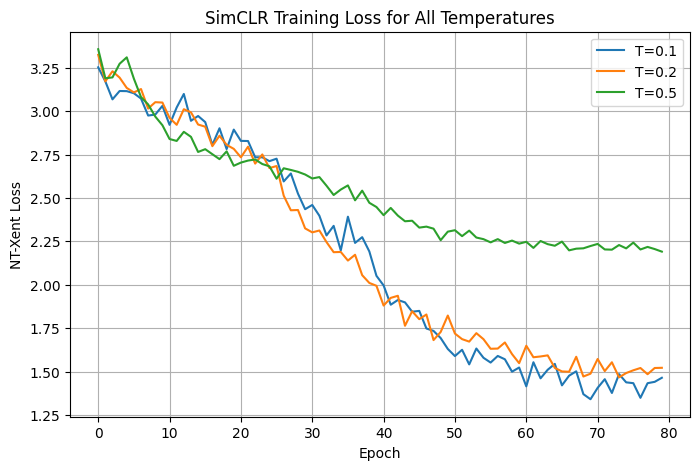

In [11]:
# STEP 6: LOSS CURVE FOR ALL TEMPERATURES

plt.figure(figsize=(8, 5))

for temp in all_loss_histories:
    losses = all_loss_histories[temp]
    plt.plot(losses, label=f"T={temp}")

plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")
plt.title("SimCLR Training Loss for All Temperatures")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# =========================
# STEP 7: MULTI-TEMP FEATURE EXTRACTION
# =========================

import torch
import numpy as np

# jodi age define na thake, tahole ekbar define kore nao:
def extract_features(backbone, dataloader, max_samples=None):
    backbone.to(cfg.DEVICE)
    backbone.eval()

    feats_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(cfg.DEVICE, non_blocking=True)
            feats = backbone(imgs)
            feats = feats.view(feats.size(0), -1)

            feats_list.append(feats.cpu())
            labels_list.append(labels.cpu())

            if max_samples is not None:
                if sum(len(x) for x in labels_list) >= max_samples:
                    break

    features = torch.cat(feats_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    if max_samples is not None and len(labels) > max_samples:
        features = features[:max_samples]
        labels = labels[:max_samples]

    return features.numpy(), labels.numpy()


# ei dictionary gula te sob temperature-er feature thakbe
features_by_temp = {}
labels_by_temp = {}

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print(f"\nExtracting features for T = {temp}")

    # Step 5 e ensure korecho:
    # all_models[temp] = simclr_model
    backbone = all_models[temp].encoder

    feats, labs = extract_features(
        backbone,
        eval_loader,
        max_samples=cfg.MAX_TSNE_POINTS  # chaile None dile full data
    )

    features_by_temp[temp] = feats
    labels_by_temp[temp] = labs

    print(f"T={temp} → Features: {feats.shape}, Labels: {labs.shape}")



Extracting features for T = 0.1
T=0.1 → Features: (1500, 2048), Labels: (1500,)

Extracting features for T = 0.2
T=0.2 → Features: (1500, 2048), Labels: (1500,)

Extracting features for T = 0.5
T=0.5 → Features: (1500, 2048), Labels: (1500,)



Running t-SNE for T = 0.1
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.341s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 4.309762
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.484688
[t-SNE] KL divergence after 1000 iterations: 0.486737


/tmp/ipykernel_47/47962984.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


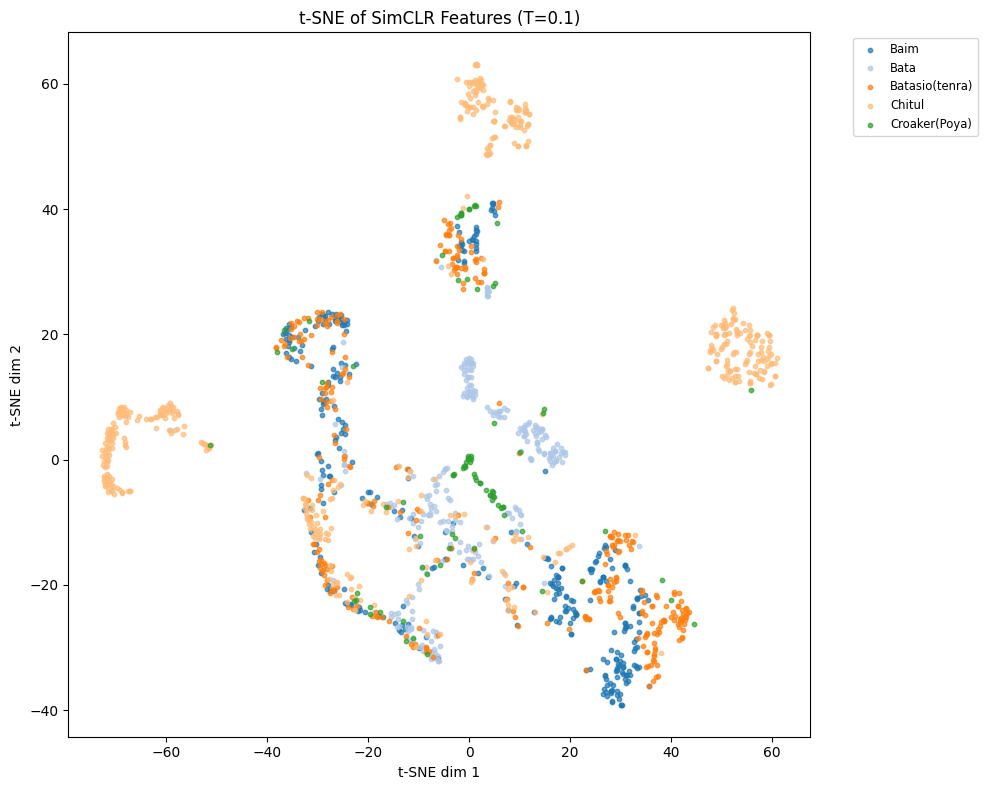


Running t-SNE for T = 0.2
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.221s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 6.143075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.439949
[t-SNE] KL divergence after 1000 iterations: 0.492771


/tmp/ipykernel_47/47962984.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


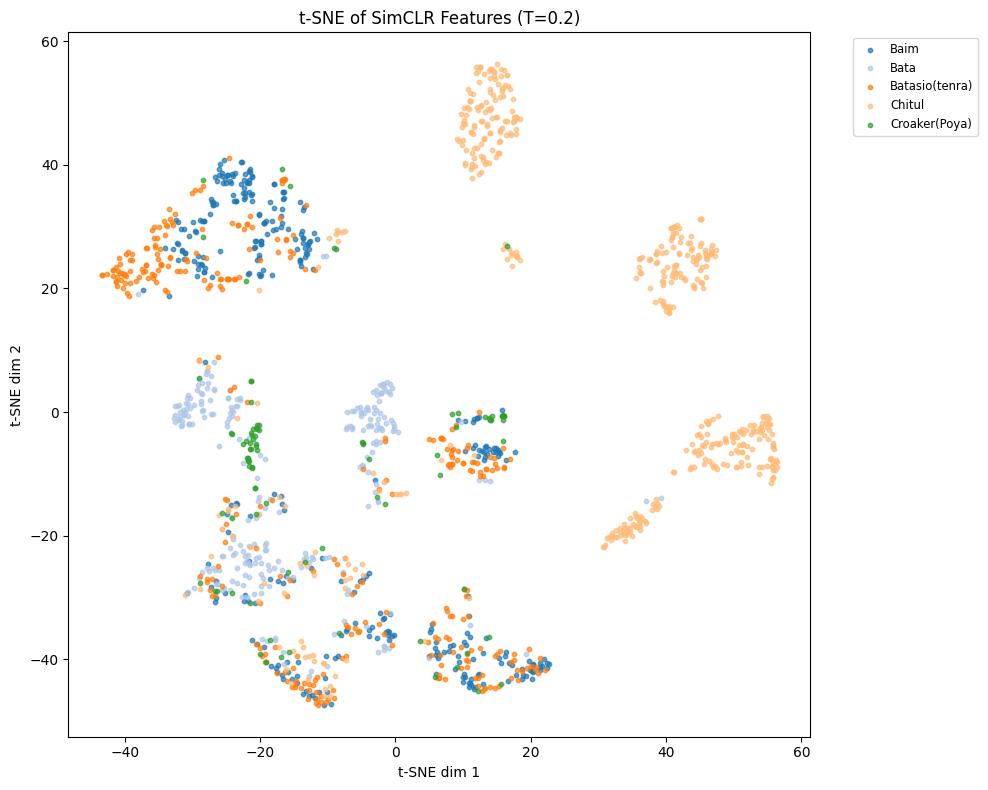


Running t-SNE for T = 0.5
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.243s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 3.956723
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.594486
[t-SNE] KL divergence after 1000 iterations: 0.446652


/tmp/ipykernel_47/47962984.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


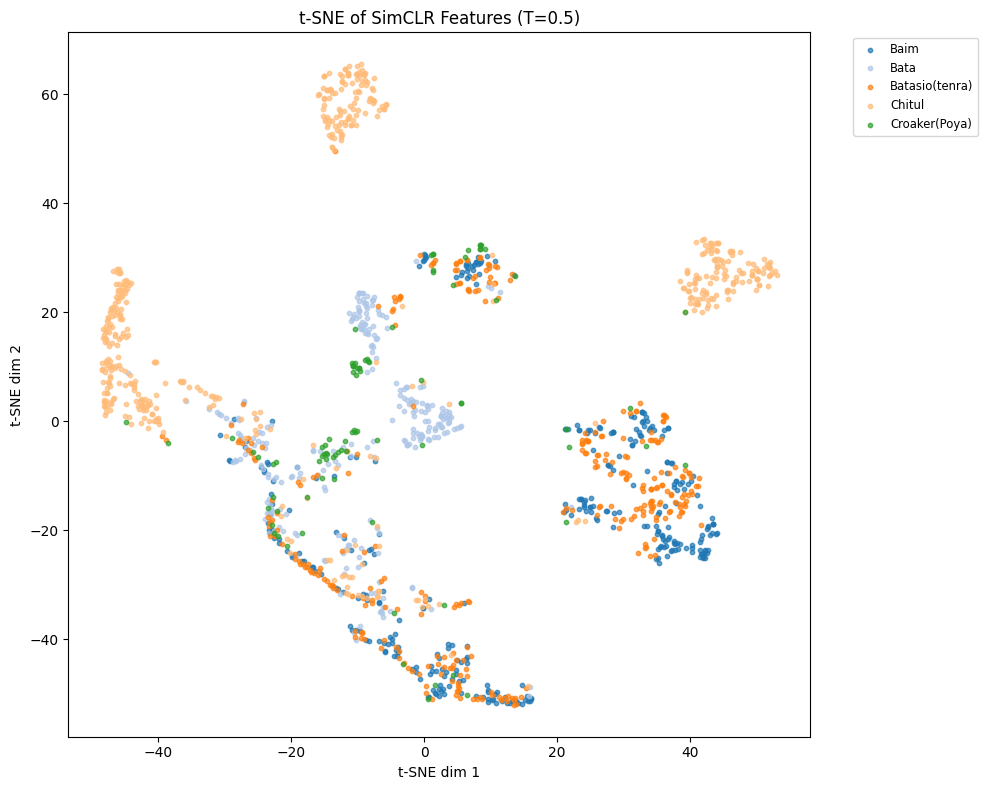

In [13]:
# =========================
# STEP 8: t-SNE FOR EACH TEMPERATURE
# =========================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print(f"\nRunning t-SNE for T = {temp}")

    tsne_features = features_by_temp[temp]
    tsne_labels = labels_by_temp[temp]

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        n_iter=1000,
        verbose=1,
        random_state=cfg.SEED
    )

    tsne_results = tsne.fit_transform(tsne_features)

    plt.figure(figsize=(10, 8))

    num_classes = len(eval_dataset.classes)
    colors = plt.cm.get_cmap('tab20', num_classes)

    for class_id in range(num_classes):
        idx = tsne_labels == class_id
        if np.sum(idx) == 0:
            continue
        plt.scatter(
            tsne_results[idx, 0],
            tsne_results[idx, 1],
            s=10,
            alpha=0.7,
            c=[colors(class_id)],
            label=eval_dataset.classes[class_id]
        )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.title(f"t-SNE of SimCLR Features (T={temp})")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.tight_layout()
    plt.show()



Linear Evaluation for Temperature = 0.1
Features: (5830, 2048) Labels: (5830,)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy for T=0.1: 51.63%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.57      0.49      0.52        68
          Bata       0.42      0.52      0.46        52
Batasio(tenra)       0.44      0.42      0.43        64
        Chitul       0.83      0.81      0.82        98
 Croaker(Poya)       0.69      0.41      0.51        22
        Hilsha       0.73      0.61      0.67        54
        Kajoli       0.35      0.61      0.45        96
          Meni       0.50      0.45      0.47        62
         Pabda       0.65      0.50      0.57        86
          Poli       0.47      0.47      0.47        34
          Puti       0.58      0.34      0.43        56
          Rita       0.64      0.27      0.38        26
           Rui       0.55      0.47      0.51        38
      Rupchada       0.50      0.47      0.48        32
   Silver Carp       0.46      0.46      0.46        28
      Telapiya       0.52      0.52      0.52      

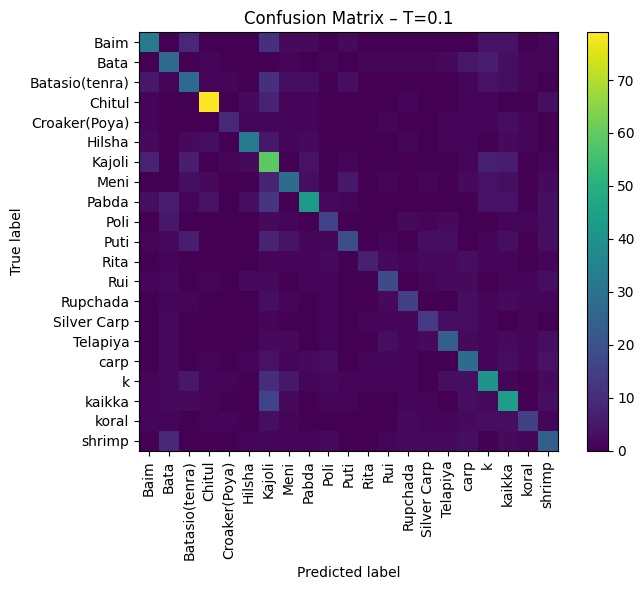


Linear Evaluation for Temperature = 0.2
Features: (5830, 2048) Labels: (5830,)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy for T=0.2: 50.60%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.58      0.53      0.55        68
          Bata       0.39      0.46      0.42        52
Batasio(tenra)       0.55      0.48      0.52        64
        Chitul       0.83      0.84      0.83        98
 Croaker(Poya)       0.64      0.41      0.50        22
        Hilsha       0.61      0.56      0.58        54
        Kajoli       0.42      0.65      0.51        96
          Meni       0.47      0.47      0.47        62
         Pabda       0.56      0.49      0.52        86
          Poli       0.42      0.32      0.37        34
          Puti       0.53      0.32      0.40        56
          Rita       0.50      0.35      0.41        26
           Rui       0.55      0.42      0.48        38
      Rupchada       0.53      0.53      0.53        32
   Silver Carp       0.58      0.25      0.35        28
      Telapiya       0.37      0.50      0.43      

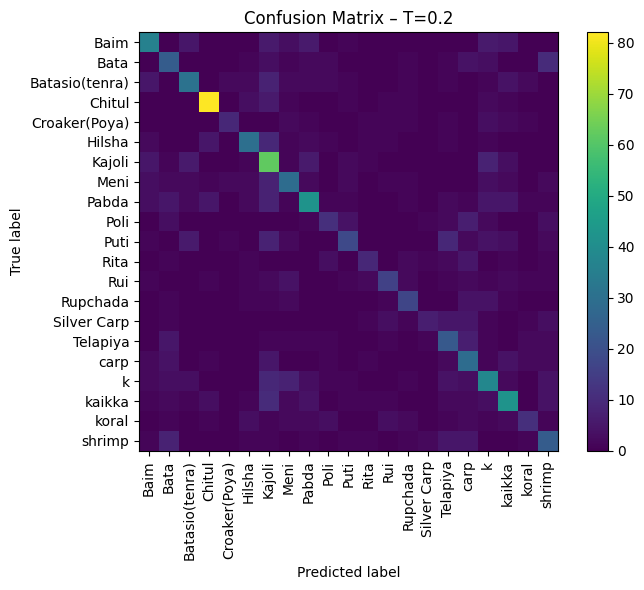


Linear Evaluation for Temperature = 0.5
Features: (5830, 2048) Labels: (5830,)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy for T=0.5: 51.03%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.59      0.50      0.54        68
          Bata       0.42      0.48      0.45        52
Batasio(tenra)       0.47      0.41      0.44        64
        Chitul       0.83      0.91      0.87        98
 Croaker(Poya)       0.53      0.41      0.46        22
        Hilsha       0.69      0.57      0.63        54
        Kajoli       0.42      0.66      0.51        96
          Meni       0.50      0.48      0.49        62
         Pabda       0.58      0.48      0.52        86
          Poli       0.58      0.44      0.50        34
          Puti       0.54      0.34      0.42        56
          Rita       0.43      0.35      0.38        26
           Rui       0.58      0.37      0.45        38
      Rupchada       0.67      0.50      0.57        32
   Silver Carp       0.52      0.50      0.51        28
      Telapiya       0.55      0.52      0.53      

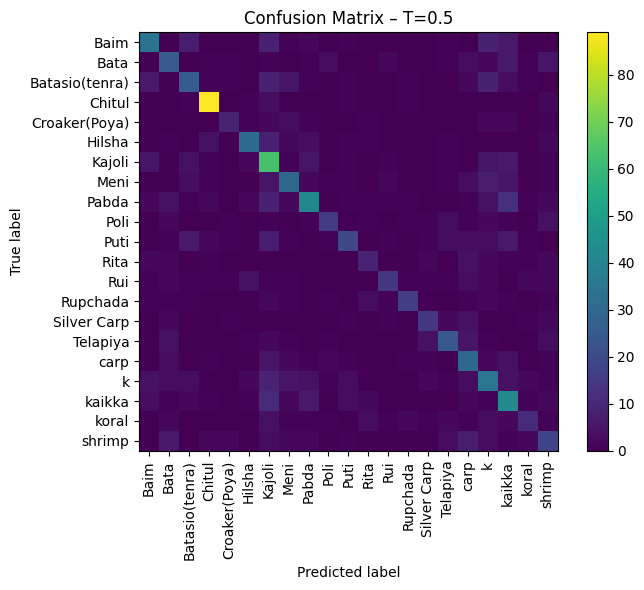


ACCURACY SUMMARY TABLE:
   Temperature  Accuracy (%)
0          0.1     51.629503
1          0.2     50.600343
2          0.5     51.029160


In [14]:
# =========================
# STEP 9: MULTI-TEMP LINEAR EVALUATION + CONFUSION MATRIX HEATMAP
# =========================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

temperature_results = {}   # sob result ekhane store hobe

TEMPERATURES = [0.1, 0.2, 0.5]

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Linear Evaluation for Temperature = {temp}")
    print("="*60)

    # backbone from that temperature's SimCLR model
    backbone = all_models[temp].encoder

    # full dataset-er feature extract
    all_features, all_labels = extract_features(
        backbone,
        eval_loader,
        max_samples=None
    )

    print("Features:", all_features.shape, "Labels:", all_labels.shape)

    # train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        all_features,
        all_labels,
        test_size=0.2,
        random_state=cfg.SEED,
        stratify=all_labels
    )

    # Logistic Regression (linear classifier)
    linear_clf = LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    )
    linear_clf.fit(X_train, y_train)

    # predictions
    y_pred = linear_clf.predict(X_val)

    # accuracy
    acc = accuracy_score(y_val, y_pred)
    print(f"\nAccuracy for T={temp}: {acc * 100:.2f}%")

    # classification report
    print("\nClassification Report:")
    print(classification_report(
        y_val, y_pred, target_names=eval_dataset.classes
    ))

    # confusion matrix (numeric)
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix (numeric):")
    print(cm)

    # confusion matrix er visual heatmap
    plt.figure(figsize=(8, 6))
    im = plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix – T={temp}")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    num_classes = len(eval_dataset.classes)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, eval_dataset.classes, rotation=90)
    plt.yticks(tick_marks, eval_dataset.classes)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

    # save all info
    temperature_results[temp] = {
        "accuracy": acc,
        "y_true": y_val,
        "y_pred": y_pred,
        "confusion_matrix": cm
    }

# small summary table of all temperatures
summary = {
    "Temperature": [],
    "Accuracy (%)": []
}

for temp in TEMPERATURES:
    summary["Temperature"].append(temp)
    summary["Accuracy (%)"].append(temperature_results[temp]["accuracy"] * 100)

df_summary = pd.DataFrame(summary)
print("\nACCURACY SUMMARY TABLE:")
print(df_summary)


In [16]:
# ======================================
# CELL 2: SHALLOW HEADS ON FROZEN FEATURES
# MLP, SVM, Decision Tree, Random Forest
# ======================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

shallow_results = {}  # {temp: {model_name: acc}}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Shallow heads for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2,
        random_state=cfg.SEED,
        stratify=y
    )

    models = {
        "MLP": make_pipeline(
            StandardScaler(),
            MLPClassifier(hidden_layer_sizes=(256, 128),
                          max_iter=300,
                          random_state=cfg.SEED)
        ),
        "SVM": make_pipeline(
            StandardScaler(),
            SVC(kernel="rbf", probability=True, random_state=cfg.SEED)
        ),
        "DecisionTree": DecisionTreeClassifier(
            max_depth=None,
            random_state=cfg.SEED
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            random_state=cfg.SEED,
            n_jobs=-1
        )
    }

    shallow_results[temp] = {}

    for name, clf in models.items():
        print(f"\n--- Training {name} ---")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        shallow_results[temp][name] = acc

        print(f"{name} Accuracy (T={temp}): {acc*100:.2f}%")
        print("Classification report:")
        print(classification_report(
            y_val, y_pred, target_names=eval_dataset.classes
        ))



Shallow heads for T = 0.1

--- Training MLP ---
MLP Accuracy (T=0.1): 49.23%
Classification report:
                precision    recall  f1-score   support

          Baim       0.52      0.47      0.49        68
          Bata       0.40      0.40      0.40        52
Batasio(tenra)       0.52      0.45      0.48        64
        Chitul       0.90      0.80      0.84        98
 Croaker(Poya)       0.62      0.36      0.46        22
        Hilsha       0.62      0.59      0.60        54
        Kajoli       0.45      0.59      0.51        96
          Meni       0.52      0.45      0.48        62
         Pabda       0.51      0.58      0.54        86
          Poli       0.42      0.38      0.40        34
          Puti       0.58      0.46      0.51        56
          Rita       0.47      0.27      0.34        26
           Rui       0.44      0.21      0.29        38
      Rupchada       0.36      0.56      0.44        32
   Silver Carp       0.44      0.39      0.42        28
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTree Accuracy (T=0.2): 37.99%
Classification report:
                precision    recall  f1-score   support

          Baim       0.45      0.44      0.45        68
          Bata       0.38      0.44      0.41        52
Batasio(tenra)       0.33      0.33      0.33        64
        Chitul       0.81      0.76      0.78        98
 Croaker(Poya)       0.41      0.32      0.36        22
        Hilsha       0.44      0.52      0.47        54
        Kajoli       0.41      0.42      0.41        96
          Meni       0.29      0.35      0.32        62
         Pabda       0.41      0.43      0.42        86
          Poli       0.30      0.26      0.28        34
          Puti       0.31      0.30      0.31        56
          Rita       0.22      0.23      0.23        26
           Rui       0.24      0.29      0.27        38
      Rupchada       0.37      0.31      0.34        32
   Silver Carp       0.17      0.18      0.17        28
      Telapiya       0.30      0.26      0

In [17]:
# ======================================
# CELL 3: FULL FINE-TUNING (BEST TEMP)
# ======================================
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

best_temp = 0.5   # jeta ke best dhorcho (change korte parba)
backbone = all_models[best_temp].encoder.backbone  # torchvision ResNet

num_classes = len(eval_dataset.classes)

class FineTuneResNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        in_dim = 2048
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)
        return logits

# full dataset = eval_dataset (ImageFolder)
full_dataset = eval_dataset

# 80% train, 20% val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(cfg.SEED)
)

train_loader_ft = DataLoader(
    train_ds,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

val_loader_ft = DataLoader(
    val_ds,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

model_ft = FineTuneResNet(backbone, num_classes).to(cfg.DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-4)
EPOCHS_FT = 10

for epoch in range(1, EPOCHS_FT + 1):
    model_ft.train()
    train_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader_ft:
        imgs = imgs.to(cfg.DEVICE)
        labels = labels.to(cfg.DEVICE)

        optimizer.zero_grad()
        logits = model_ft(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = logits.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total * 100

    # validation
    model_ft.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader_ft:
            imgs = imgs.to(cfg.DEVICE)
            labels = labels.to(cfg.DEVICE)

            logits = model_ft(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            _, preds = logits.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total * 100

    print(f"[FT T={best_temp}] Epoch {epoch}/{EPOCHS_FT} "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


[FT T=0.5] Epoch 1/10 Train Loss: 2.5138, Train Acc: 20.82% | Val Loss: 2.2595, Val Acc: 26.07%
[FT T=0.5] Epoch 2/10 Train Loss: 2.3031, Train Acc: 25.94% | Val Loss: 2.1734, Val Acc: 28.13%
[FT T=0.5] Epoch 3/10 Train Loss: 2.1982, Train Acc: 29.10% | Val Loss: 2.0468, Val Acc: 34.48%
[FT T=0.5] Epoch 4/10 Train Loss: 2.1056, Train Acc: 32.72% | Val Loss: 1.9870, Val Acc: 36.11%
[FT T=0.5] Epoch 5/10 Train Loss: 2.0204, Train Acc: 35.96% | Val Loss: 1.9332, Val Acc: 37.99%
[FT T=0.5] Epoch 6/10 Train Loss: 1.9332, Train Acc: 38.12% | Val Loss: 1.8553, Val Acc: 41.17%
[FT T=0.5] Epoch 7/10 Train Loss: 1.8781, Train Acc: 40.39% | Val Loss: 1.8378, Val Acc: 42.20%
[FT T=0.5] Epoch 8/10 Train Loss: 1.8215, Train Acc: 42.11% | Val Loss: 1.7075, Val Acc: 45.97%
[FT T=0.5] Epoch 9/10 Train Loss: 1.7668, Train Acc: 43.78% | Val Loss: 1.7707, Val Acc: 44.43%
[FT T=0.5] Epoch 10/10 Train Loss: 1.7346, Train Acc: 44.77% | Val Loss: 1.7051, Val Acc: 45.54%


In [19]:
# ===== COMPAT PATCH FOR UMAP + OLD SKLEARN =====
import umap.umap_ as umap_mod
from sklearn.utils.validation import check_array as sk_check_array

def check_array_compat(*args, **kwargs):
    # umap sometimes passes ensure_all_finite, but old sklearn doesn't accept it
    kwargs.pop("ensure_all_finite", None)
    return sk_check_array(*args, **kwargs)

umap_mod.check_array = check_array_compat
print("Patched UMAP check_array() for sklearn compatibility.")


Patched UMAP check_array() for sklearn compatibility.



Embedding Analysis for T = 0.1


/tmp/ipykernel_47/4146294890.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_classes)


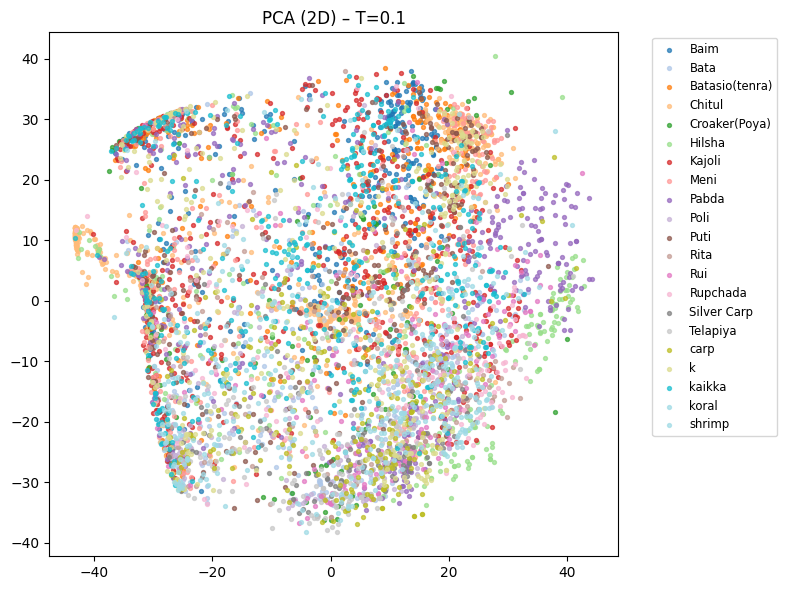

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


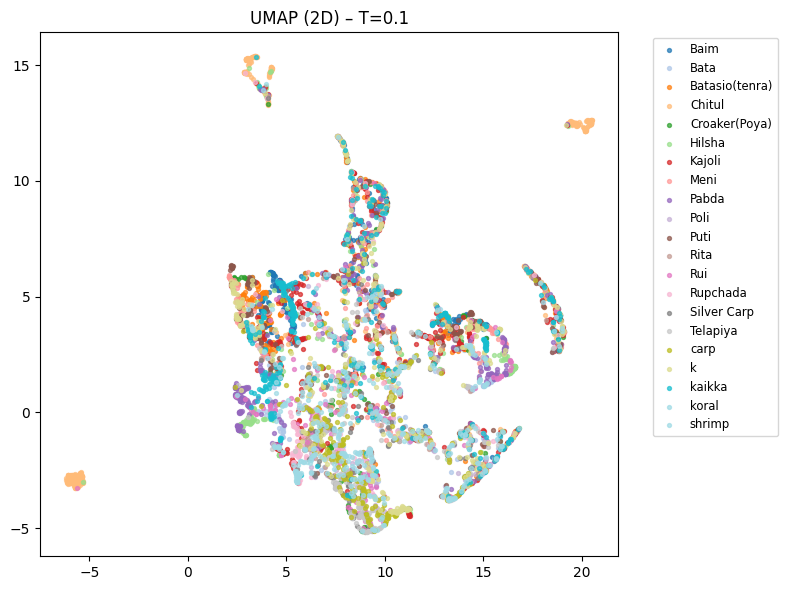

Silhouette score (T=0.1): -0.1036

Embedding Analysis for T = 0.2


/tmp/ipykernel_47/4146294890.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_classes)


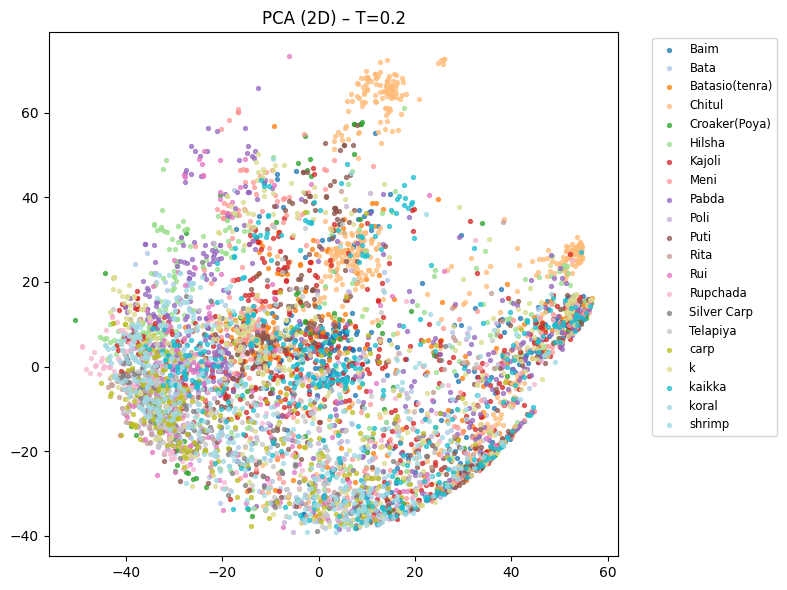

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


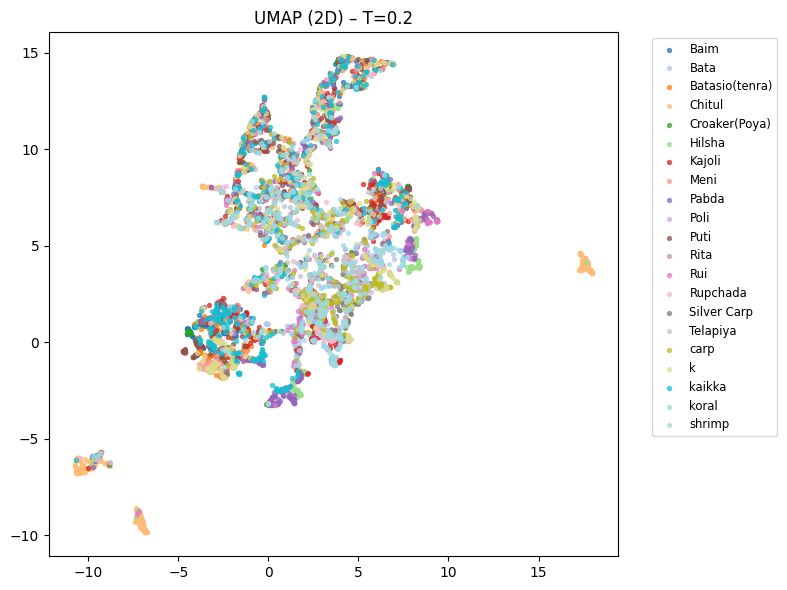

Silhouette score (T=0.2): -0.0937

Embedding Analysis for T = 0.5


/tmp/ipykernel_47/4146294890.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_classes)


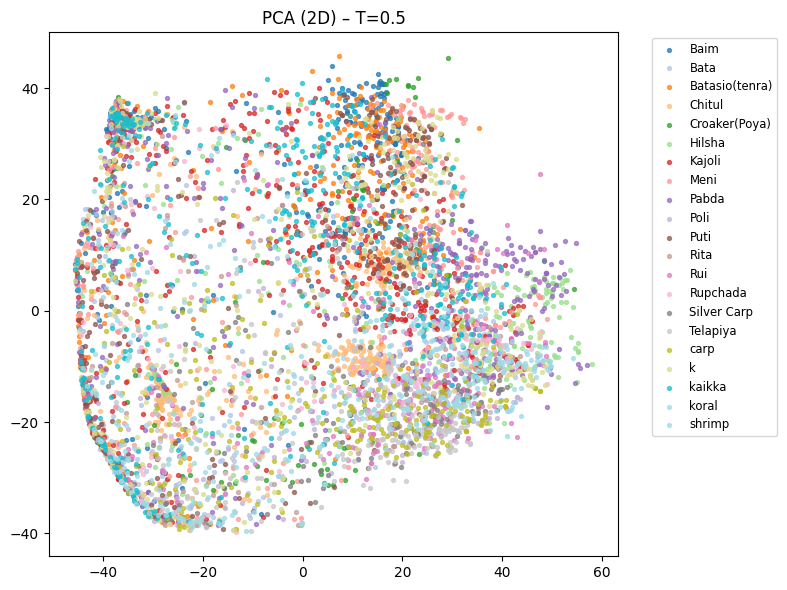

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


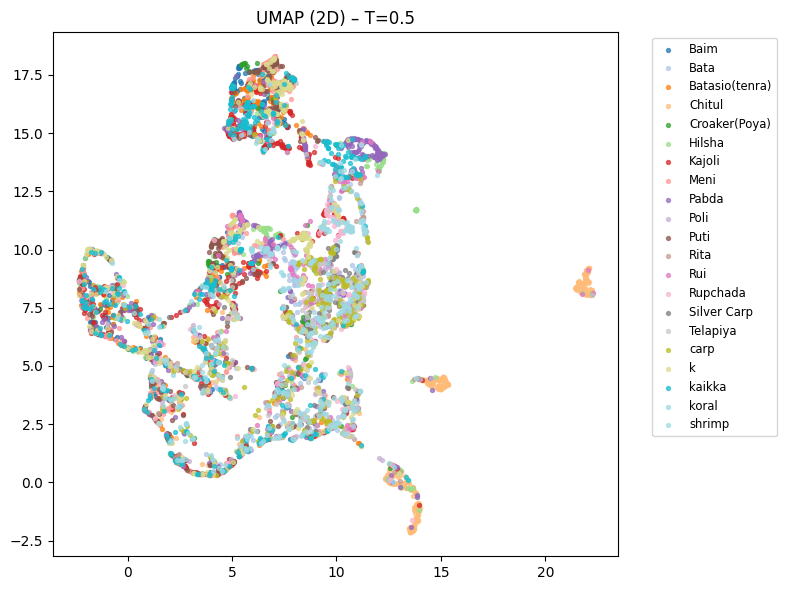

Silhouette score (T=0.5): -0.0877


In [20]:
# ======================================
# CELL 4: UMAP, PCA, SILHOUETTE SCORE
# ======================================
!pip install -q umap-learn

import umap
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Embedding Analysis for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    # --- PCA 2D ---
    pca = PCA(n_components=2, random_state=cfg.SEED)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    num_classes = len(eval_dataset.classes)
    colors = plt.cm.get_cmap("tab20", num_classes)

    for c in range(num_classes):
        idx = (y == c)
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                    s=8, alpha=0.7, c=[colors(c)], label=eval_dataset.classes[c])
    plt.title(f"PCA (2D) – T={temp}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()

    # --- UMAP 2D ---
    reducer = umap.UMAP(
        n_components=2,
        random_state=cfg.SEED,
        n_neighbors=15,
        min_dist=0.1
    )
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(8, 6))
    for c in range(num_classes):
        idx = (y == c)
        plt.scatter(X_umap[idx, 0], X_umap[idx, 1],
                    s=8, alpha=0.7, c=[colors(c)], label=eval_dataset.classes[c])
    plt.title(f"UMAP (2D) – T={temp}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()

    # --- Silhouette score (w.r.t true labels) ---
    sil = silhouette_score(X, y)
    print(f"Silhouette score (T={temp}): {sil:.4f}")



In [21]:
# ======================================
# CELL 5: k-NN ACCURACY IN EMBEDDING SPACE
# ======================================
from sklearn.neighbors import KNeighborsClassifier

knn_results = {}  # {temp: {k: acc}}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"k-NN accuracy for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2,
        random_state=cfg.SEED,
        stratify=y
    )

    knn_results[temp] = {}
    for k in [1, 5, 20]:
        clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        knn_results[temp][k] = acc
        print(f"k = {k}, T={temp} → Accuracy: {acc*100:.2f}%")



k-NN accuracy for T = 0.1
k = 1, T=0.1 → Accuracy: 48.46%
k = 5, T=0.1 → Accuracy: 44.25%
k = 20, T=0.1 → Accuracy: 37.31%

k-NN accuracy for T = 0.2
k = 1, T=0.2 → Accuracy: 45.37%
k = 5, T=0.2 → Accuracy: 41.85%
k = 20, T=0.2 → Accuracy: 38.25%

k-NN accuracy for T = 0.5
k = 1, T=0.5 → Accuracy: 46.40%
k = 5, T=0.5 → Accuracy: 41.34%
k = 20, T=0.5 → Accuracy: 36.71%



Label Efficiency for T = 0.1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=1% labels, T=0.1 → Acc: 16.98%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=5% labels, T=0.1 → Acc: 26.16%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=10% labels, T=0.1 → Acc: 31.39%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=25% labels, T=0.1 → Acc: 39.88%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=50% labels, T=0.1 → Acc: 46.91%

Label Efficiency for T = 0.2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=1% labels, T=0.2 → Acc: 13.89%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=5% labels, T=0.2 → Acc: 29.42%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=10% labels, T=0.2 → Acc: 32.85%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed`

Frac=25% labels, T=0.2 → Acc: 41.51%
Frac=50% labels, T=0.2 → Acc: 46.66%

Label Efficiency for T = 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=1% labels, T=0.5 → Acc: 17.24%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=5% labels, T=0.5 → Acc: 25.99%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=10% labels, T=0.5 → Acc: 31.30%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=25% labels, T=0.5 → Acc: 40.65%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Frac=50% labels, T=0.5 → Acc: 46.14%


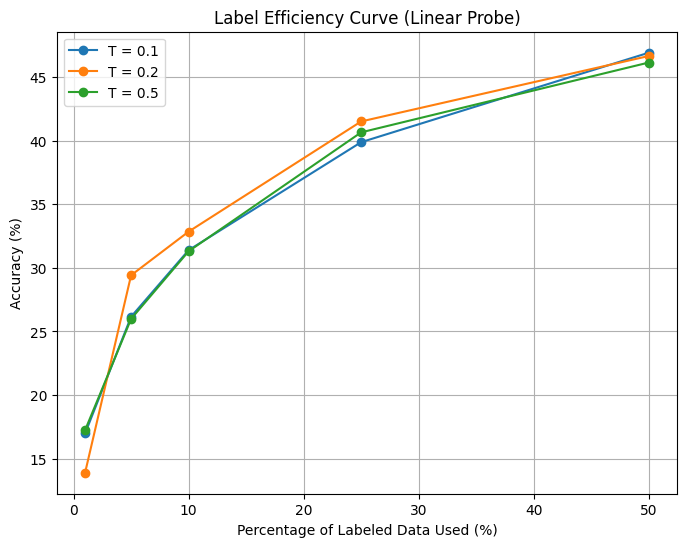

In [23]:
# ======================================
# CELL 6: LABEL-EFFICIENCY CURVES (LINEAR PROBE)
# ======================================
fractions = [0.01, 0.05, 0.10, 0.25, 0.50]

from sklearn.linear_model import LogisticRegression

label_efficiency = {}  # {temp: {fraction: acc}}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Label Efficiency for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    X_full_train, X_val, y_full_train, y_val = train_test_split(
        X, y, test_size=0.2,
        random_state=cfg.SEED,
        stratify=y
    )

    label_efficiency[temp] = {}

    for frac in fractions:
        n_samples = int(len(X_full_train) * frac)
        if n_samples < len(np.unique(y)):
            n_samples = len(np.unique(y))

        # Select only frac% of labeled data
        X_sub, _, y_sub, _ = train_test_split(
            X_full_train, y_full_train,
            train_size=n_samples,
            random_state=cfg.SEED,
            stratify=y_full_train
        )

        # Train linear classifier
        clf = LogisticRegression(max_iter=2000, n_jobs=-1)
        clf.fit(X_sub, y_sub)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)

        label_efficiency[temp][frac] = acc
        print(f"Frac={frac*100:.0f}% labels, T={temp} → Acc: {acc*100:.2f}%")

# ======================================
# PLOT LABEL EFFICIENCY CURVE (3 TEMPS)
# ======================================
plt.figure(figsize=(8, 6))

for temp in TEMPERATURES:
    accs = [label_efficiency[temp][f] * 100 for f in fractions]
    plt.plot([f * 100 for f in fractions], accs, marker="o", label=f"T = {temp}")

plt.title("Label Efficiency Curve (Linear Probe)")
plt.xlabel("Percentage of Labeled Data Used (%)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro ROC–AUC (T=0.5): 0.8714


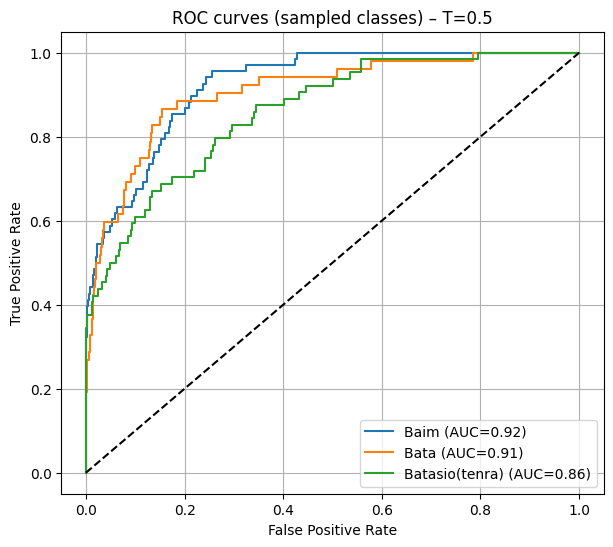

In [24]:
# ======================================
# CELL 7: ROC–AUC & ROC CURVE (BEST TEMP, LINEAR PROBE)
# ======================================
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

best_temp = 0.5   # jeta ke best dhorcho
X = features_by_temp[best_temp]
y = labels_by_temp[best_temp]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2,
    random_state=cfg.SEED,
    stratify=y
)

# Logistic regression with probability
clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_val)
y_bin = label_binarize(y_val, classes=np.arange(len(eval_dataset.classes)))

roc_auc_macro = roc_auc_score(y_bin, y_proba, multi_class="ovr", average="macro")
print(f"Macro ROC–AUC (T={best_temp}): {roc_auc_macro:.4f}")

# example: plot ROC curve for 3 random classes or first 3
plt.figure(figsize=(7, 6))
for i in range(min(3, y_proba.shape[1])):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{eval_dataset.classes[i]} (AUC={auc_i:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curves (sampled classes) – T={best_temp}")
plt.legend()
plt.grid(True)
plt.show()
